# Purpose
* This analysis is looking at the cancellation rate for manga run in Shonen Jump 
* The main hypothesis is that the magazine has cancelled less series than usual this year

Note: This was created a few months ago so my understanding of data science and programming practices is less robust than my taskmaster data science project (https://github.com/davidmwein/data_science/blob/main/taskmaster_data_science.ipynb)

In [4]:
import pandas as pd
import pygs
#import icetools_esg.ice_core as ic_esg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#don't show warning flags
pd.options.mode.chained_assignment = None
from scipy.stats import pearsonr
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

Note: Time between cancelations can be slightly missleading if there is an off week for the magazine which occurs 4x times a year

# Bring in data and get ready for analysis

## Import and clean data

In [5]:
shonen_jump_schedule = pygs.read_google_sheet(spreadsheetId = "16pToYnYcppeE6f43pY73ebLa9Zeaz_cLFC1icL3MrLg",sheet_name="Master Shonen Jump List")
#only WSJ
shonen_jump_schedule = shonen_jump_schedule.loc[shonen_jump_schedule['Magazine'] == 'Weekly Shonen Jump']
#no ongoing series
shonen_jump_schedule = shonen_jump_schedule.loc[shonen_jump_schedule['End'] != 'Ongoing']
#remove not needed fields
shonen_jump_schedule = shonen_jump_schedule[['English Title','Chp.','Author(s)','Start','End','Years']]
#rename fields
shonen_jump_schedule.rename({'English Title': 'title','Chp.': 'chapters','Author(s)': 'authors','Start': 'start','End': 'end','Years': 'run_years'}, axis =1, inplace=True)

In [6]:
shonen_jump_schedule.head()

,title,chapters,authors,start,end,run_years
0,Kujira Daigo,11,Sachio Uemoto,08/01/1968,12/26/1968,0.4
1,Chichi no Tamashii,128,Hiroshi Kaizuka,08/01/1968,10/25/1971,3.2
2,Harenchi Gakuen,116,Go Nagai,08/01/1968,9/25/1972,4.2
3,Ore wa Kamikaze,21,Toshio Shoji,09/12/1968,7/10/1969,0.8
4,Manga Konto 55-go,60,Naoya Kusumoto,11/14/1968,7/20/1970,1.7


In [7]:
#check for nulls
shonen_jump_schedule.isnull().sum()
#no missing data issues

title        0
chapters     0
authors      0
start        0
end          0
run_years    0
dtype: int64

In [8]:
shonen_jump_schedule.dtypes

title        object
chapters     object
authors      object
start        object
end          object
run_years    object
dtype: object

In [9]:
#convert datatypes
shonen_jump_schedule['start'] = pd.to_datetime(shonen_jump_schedule['start'], format='%m/%d/%Y')

In [10]:
#get magazine start date for first series axed
sj_start_date = shonen_jump_schedule['start'].min()

In [11]:
shonen_jump_schedule['chapters'] = pd.to_numeric(shonen_jump_schedule['chapters'], errors='coerce')
#drop manga with less than 8 chapters to omit miniseries and more than 100 as that's too succesful
shonen_jump_schedule = shonen_jump_schedule.loc[(shonen_jump_schedule['chapters'] >= 8) & (shonen_jump_schedule['chapters'] <= 100)]
shonen_jump_schedule['run_years'] = pd.to_numeric(shonen_jump_schedule['run_years'], errors='coerce')
shonen_jump_schedule['end'] = pd.to_datetime(shonen_jump_schedule['end'], format='%m/%d/%Y')

In [12]:
#add in magazine start date as a title
shonen_jump_schedule.loc[len(shonen_jump_schedule.index)] = ['Magazine Start', 0, 'N/A', sj_start_date,sj_start_date,0] 

In [13]:
#order by end date
shonen_jump_schedule = shonen_jump_schedule.sort_values(by=['end','run_years'])
#reset index so it looks better
shonen_jump_schedule = shonen_jump_schedule.reset_index()
shonen_jump_schedule.drop(['index'],axis=1, inplace=True)

In [14]:
shonen_jump_schedule.dtypes

title                object
chapters            float64
authors              object
start        datetime64[ns]
end          datetime64[ns]
run_years           float64
dtype: object

## Calculated fields

In [15]:
#get cancel difference in weeks
shonen_jump_schedule['cancel_diff_weeks'] = shonen_jump_schedule['end'].diff() / np.timedelta64(1, 'W')

In [16]:
#some series were cancelled on the same day, accounts for this by getting max value
shonen_jump_schedule['cancel_diff_weeks'] = shonen_jump_schedule.groupby('end').cancel_diff_weeks.transform('max')

In [17]:
shonen_jump_schedule.head()

,title,chapters,authors,start,end,run_years,cancel_diff_weeks
0,Magazine Start,0.0,N/A,1968-08-01,1968-08-01,0.0,NaN
1,Kujira Daigo,11.0,Sachio Uemoto,1968-08-01,1968-12-26,0.4,21.000000
2,Ore wa Kamikaze,21.0,Toshio Shoji,1968-09-12,1969-07-10,0.8,28.000000
3,Bakuhatsu Yaro,14.0,Sachio Uemoto,1969-01-09,1969-07-24,0.5,2.000000
4,Kurohige Tanteicho,14.0,George Akiyama,1969-03-27,1969-10-13,0.5,11.571429


In [18]:
#qa function works as expected
shonen_jump_schedule.loc[(shonen_jump_schedule['end'] == '2018-07-09')]

,title,chapters,authors,start,end,run_years,cancel_diff_weeks
498,Ziga,14.0,"Rokuro Sano, Kentaro Hidano",2018-04-02,2018-07-09,0.3,10.0
499,Robot x LaserBeam,62.0,Tadatoshi Fujimaki,2017-04-03,2018-07-09,1.3,10.0


In [19]:
#drop fake row
shonen_jump_schedule = shonen_jump_schedule.loc[(shonen_jump_schedule['title'] != 'Magazine Start')]

In [20]:
#round weeks up
shonen_jump_schedule['cancel_diff_weeks'] = shonen_jump_schedule['cancel_diff_weeks'].round(0).astype(int)

In [21]:
#add years to normalize dates
shonen_jump_schedule['start_year'] = pd.DatetimeIndex(shonen_jump_schedule['start']).year
shonen_jump_schedule['end_year'] = pd.DatetimeIndex(shonen_jump_schedule['end']).year

In [22]:
#decades for broader analysis
shonen_jump_schedule['start_decade'] = shonen_jump_schedule['start_year'] - (shonen_jump_schedule['start_year']%10)
shonen_jump_schedule['end_decade'] = shonen_jump_schedule['end_year'] - (shonen_jump_schedule['end_year']%10)

In [23]:
#remove before 1970 as there's not a lot of data
shonen_jump_schedule = shonen_jump_schedule.loc[(shonen_jump_schedule['end_decade'] > 1960)]

In [24]:
#used for getting count of series
shonen_jump_schedule['series_count'] = 1

In [25]:
#break down series into length groups for potential future analysis about the nature of the cancelations
#Under 19 is a specific classification in Shonen Jump discussion, 50 was considered a good midrange number
shonen_jump_schedule['length_group'] = pd.cut(x=shonen_jump_schedule['chapters'], bins=[1, 18, 50, 99],
                    labels=['short', 'medium', 'long'])

Data should now be ready for analysis

In [26]:
shonen_jump_schedule

,title,chapters,authors,start,end,run_years,cancel_diff_weeks,start_year,end_year,start_decade,end_decade,series_count,length_group
7,Mosa,11.0,Tetsuya Chiba,1969-11-03,1970-01-12,0.2,6,1969,1970,1960,1970,1,short
8,Akatsuka Gag Shotaiseki,13.0,"Fujio Akatsuka, Mitsutoshi Furuya",1969-11-03,1970-02-02,0.2,3,1969,1970,1960,1970,1,short
9,Dodo Yaro,17.0,Noburo Kawasaki,1969-11-03,1970-03-02,0.3,4,1969,1970,1960,1970,1,short
10,Ore to Omae to Aitsu,9.0,Makoto Ippongi,1969-11-17,1970-03-16,0.3,2,1969,1970,1960,1970,1,short
11,Animal Kyujo,11.0,Haruna Mayuzuki,1970-01-05,1970-03-23,0.2,1,1970,1970,1970,1970,1,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,The Hunters Guild: Red Hood,18.0,Kawaguchi Yuuki,2021-07-12,2021-11-22,0.4,8,2021,2021,2020,2020,1,short
531,Neru: Way of the Martial Artist,18.0,Hiraga Minya,2021-07-19,2021-11-29,0.4,1,2021,2021,2020,2020,1,short
532,Magu-chan: God of Destruction,77.0,Kei Kamiki,2020-07-06,2022-02-21,1.6,12,2020,2022,2020,2020,1,long
533,Ayashimon,25.0,Yuji Kaku,2021-11-29,2022-06-13,0.5,16,2021,2022,2020,2020,1,medium


## Create Year/Decade aggregations

In [27]:
shonen_jump_yearly = shonen_jump_schedule.groupby(['end_year','end_decade']).agg({'run_years':'median', 'chapters':'median', 'cancel_diff_weeks' : 'median', 'series_count' : 'sum'}).reset_index()
shonen_jump_yearly.head(10)

,end_year,end_decade,run_years,chapters,cancel_diff_weeks,series_count
0,1970,1970,0.30,15.0,3.0,20
1,1971,1970,0.30,15.0,2.5,14
2,1972,1970,0.20,11.0,4.0,11
3,1973,1970,0.35,18.0,6.0,10
4,1974,1970,0.35,16.5,9.5,6
5,1975,1970,1.10,44.0,3.5,8
6,1976,1970,0.30,15.5,4.0,10
7,1977,1970,0.30,15.5,6.5,10
8,1978,1970,0.20,11.0,5.5,6
9,1979,1970,0.20,12.0,7.0,11


In [28]:
shonen_jump_decade = shonen_jump_schedule.groupby(['end_decade']).agg({'run_years':'median', 'chapters':'median', 'cancel_diff_weeks' : 'median', 'series_count' : 'sum'}).reset_index()
shonen_jump_decade.rename({'end_decade': 'end_year'}, axis =1, inplace=True)
shonen_jump_decade

,end_year,run_years,chapters,cancel_diff_weeks,series_count
0,1970,0.30,15.0,4.0,106
1,1980,0.30,15.0,4.0,120
2,1990,0.30,17.0,4.0,102
3,2000,0.30,18.0,4.0,85
4,2010,0.40,19.0,6.0,93
5,2020,0.45,23.0,2.5,22


## Basic statistics

In [ ]:
shonen_jump_schedule.describe()

In [29]:
shonen_jump_yearly.describe()

,end_year,end_decade,run_years,chapters,cancel_diff_weeks,series_count
count,53.000000,53.000000,53.00000,53.000000,53.000000,53.000000
mean,1996.000000,1991.698113,0.34717,18.358491,4.990566,9.962264
std,15.443445,15.533568,0.14224,5.463495,2.622921,2.961044
min,1970.000000,1970.000000,0.20000,11.000000,1.000000,3.000000
25%,1983.000000,1980.000000,0.30000,15.500000,3.000000,8.000000
50%,1996.000000,1990.000000,0.30000,18.000000,4.000000,10.000000
75%,2009.000000,2000.000000,0.40000,20.000000,6.500000,11.000000
max,2022.000000,2020.000000,1.10000,44.000000,12.000000,20.000000


In [30]:
shonen_jump_decade.describe()

,end_year,run_years,chapters,cancel_diff_weeks,series_count
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,1995.000000,0.341667,17.833333,4.083333,88.000000
std,18.708287,0.066458,2.994439,1.114301,34.449964
min,1970.000000,0.300000,15.000000,2.500000,22.000000
25%,1982.500000,0.300000,15.500000,4.000000,87.000000
50%,1995.000000,0.300000,17.500000,4.000000,97.500000
75%,2007.500000,0.375000,18.750000,4.000000,105.000000
max,2020.000000,0.450000,23.000000,6.000000,120.000000


# Hypothesis: Is Shonen Jump giving more time before cancellations this year (2022)

This can be shown three ways:
- Longer gaps between cancellations
- Longer run times of series before cancelation
- Less cancelations per year

In [31]:
#establish size of viz
sns.set(rc={"figure.figsize":(15, 6)})

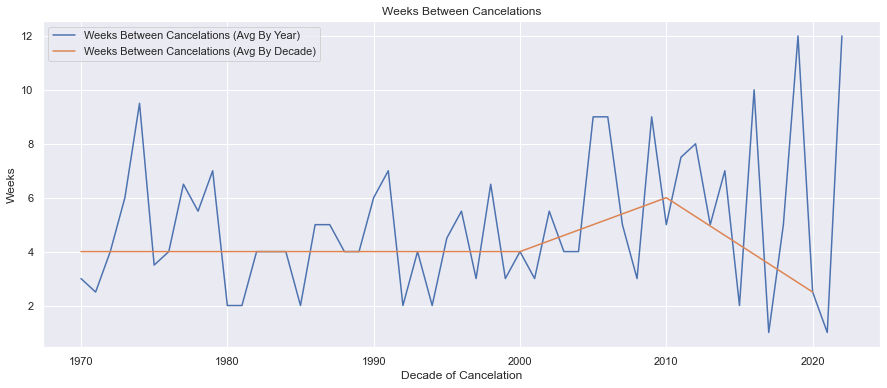

In [32]:
sns.lineplot(x="end_year", y="cancel_diff_weeks", data=shonen_jump_yearly) 
sns.lineplot(x="end_year", y="cancel_diff_weeks", data=shonen_jump_decade) 
plt.xlabel("Decade of Cancelation")
plt.ylabel("Weeks")
plt.title("Weeks Between Cancelations")
plt.legend(labels=["Weeks Between Cancelations (Avg By Year)","Weeks Between Cancelations (Avg By Decade)"])

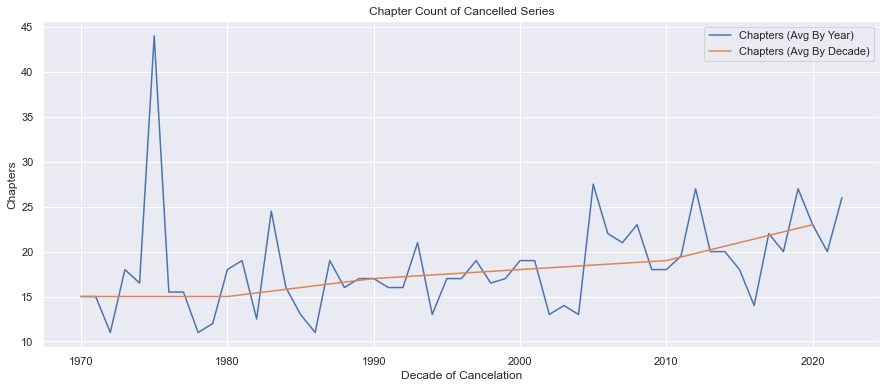

In [33]:
sns.lineplot(x="end_year", y="chapters", data=shonen_jump_yearly) 
sns.lineplot(x="end_year", y="chapters", data=shonen_jump_decade) 
plt.xlabel("Decade of Cancelation")
plt.ylabel("Chapters")
plt.title("Chapter Count of Cancelled Series") # You can comment this line out if you don't need title
plt.legend(labels=["Chapters (Avg By Year)","Chapters (Avg By Decade)"])

Text(0.5, 1.0, 'Cancellations By Year')

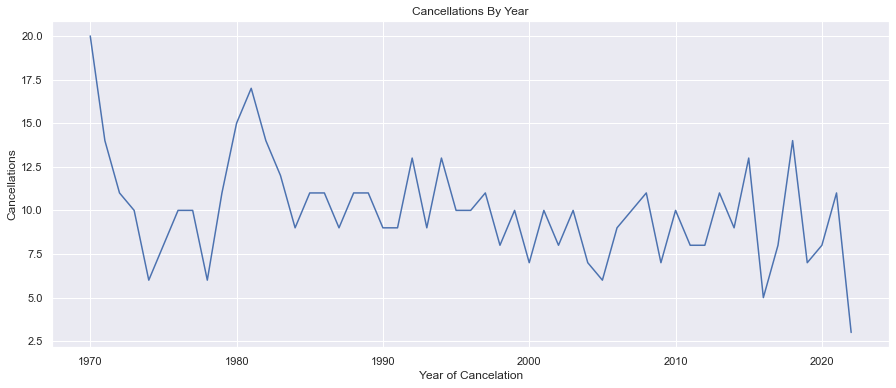

In [34]:
sns.lineplot(x="end_year", y="series_count", data=shonen_jump_yearly) 
plt.xlabel("Year of Cancelation")
plt.ylabel("Cancellations")
plt.title("Cancellations By Year") 

Text(0.5, 1.0, 'Cancellations By Decade')

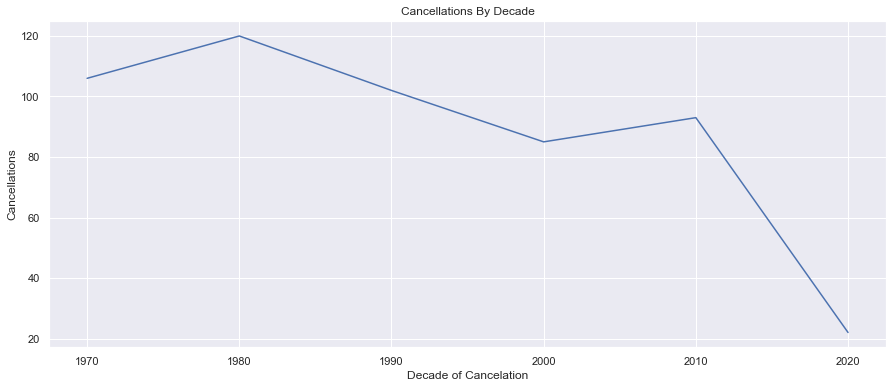

In [35]:
sns.lineplot(x="end_year", y="series_count", data=shonen_jump_decade)
plt.xlabel("Decade of Cancelation")
plt.ylabel("Cancellations")
plt.title("Cancellations By Decade") 

There is a downtrend in 2022 in all metrics of cancellations

## Hypothesis:  There is a correlation between average run time of manga and time between cancellations

### Viz cancelation vs chapter length

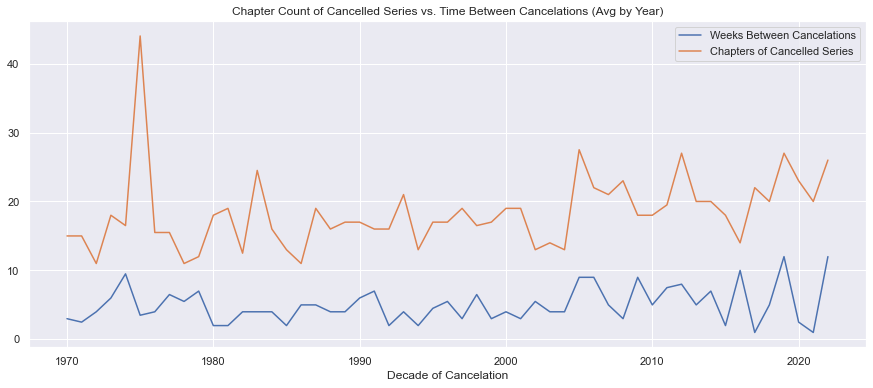

In [36]:
sns.lineplot(x="end_year", y="cancel_diff_weeks", data=shonen_jump_yearly) 
sns.lineplot(x="end_year", y="chapters", data=shonen_jump_yearly) 
plt.xlabel("Decade of Cancelation")
plt.ylabel("")
plt.title("Chapter Count of Cancelled Series vs. Time Between Cancelations (Avg by Year)") 
plt.legend(labels=["Weeks Between Cancelations","Chapters of Cancelled Series"])

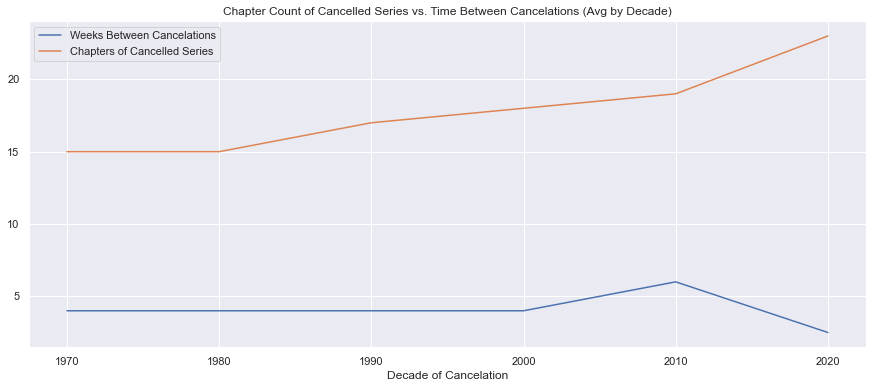

In [37]:
sns.lineplot(x="end_year", y="cancel_diff_weeks", data=shonen_jump_decade) 
sns.lineplot(x="end_year", y="chapters", data=shonen_jump_decade) 
plt.xlabel("Decade of Cancelation")
plt.ylabel("")
plt.title("Chapter Count of Cancelled Series vs. Time Between Cancelations (Avg by Decade)") 
plt.legend(labels=["Weeks Between Cancelations","Chapters of Cancelled Series"])

Text(0.5, 1.0, 'Weeks Between Cancelations vs. Chapter Length of Cancelled Series')

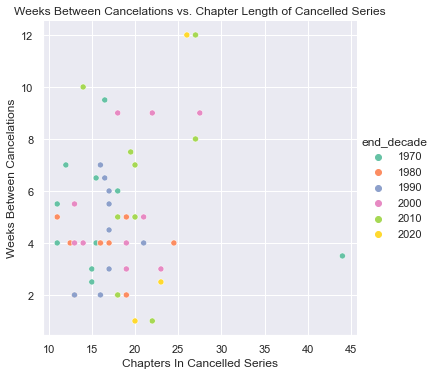

In [38]:
sns.relplot(x="chapters", y="cancel_diff_weeks", data=shonen_jump_yearly, hue='end_decade', palette = 'Set2')
plt.xlabel("Chapters In Cancelled Series")
plt.ylabel("Weeks Between Cancelations")
plt.title("Weeks Between Cancelations vs. Chapter Length of Cancelled Series")

Text(0.5, 1.0, 'Weeks Between Cancelations vs. Chapter Length of Cancelled Series')

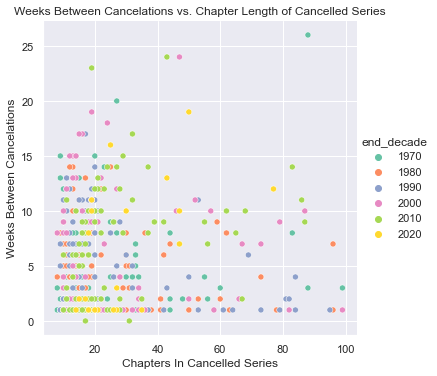

In [39]:
sns.relplot(x="chapters", y="cancel_diff_weeks", data=shonen_jump_schedule, hue='end_decade', palette = 'Set2')
plt.xlabel("Chapters In Cancelled Series")
plt.ylabel("Weeks Between Cancelations")
plt.title("Weeks Between Cancelations vs. Chapter Length of Cancelled Series")

### Look at correlation

In [40]:
#look at correlation from chapters vs cancel frequency
corr, _ = pearsonr(shonen_jump_yearly['chapters'], shonen_jump_yearly['cancel_diff_weeks'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.174


In [41]:
corr, _ = spearmanr(shonen_jump_yearly['chapters'], shonen_jump_yearly['cancel_diff_weeks'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.088


There is a positive correlation but it is not very strong (less than .5)

# Interesting Misc Stats

In [42]:
print(shonen_jump_schedule['chapters'].mean())
#most cancelations in a year

24.03787878787879


Text(0.5, 0, 'Weeks between cancelation')

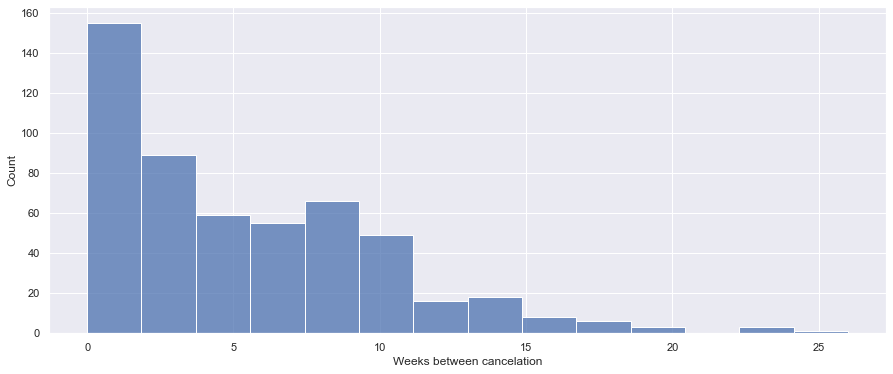

In [43]:
sns.histplot(x="cancel_diff_weeks", data=shonen_jump_schedule) 
plt.xlabel("Weeks between cancelation")

Text(0.5, 0, 'Chapter length cancelled series')

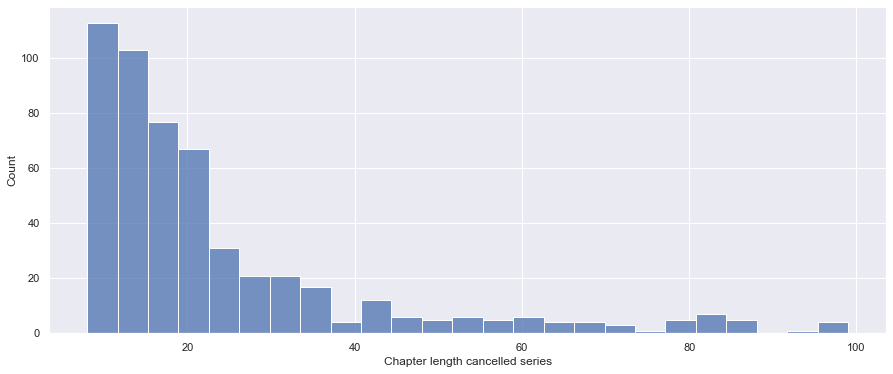

In [44]:
sns.histplot(x="chapters", data=shonen_jump_schedule)
plt.xlabel("Chapter length cancelled series")

Text(0.5, 1.0, 'Cancellations By Year')

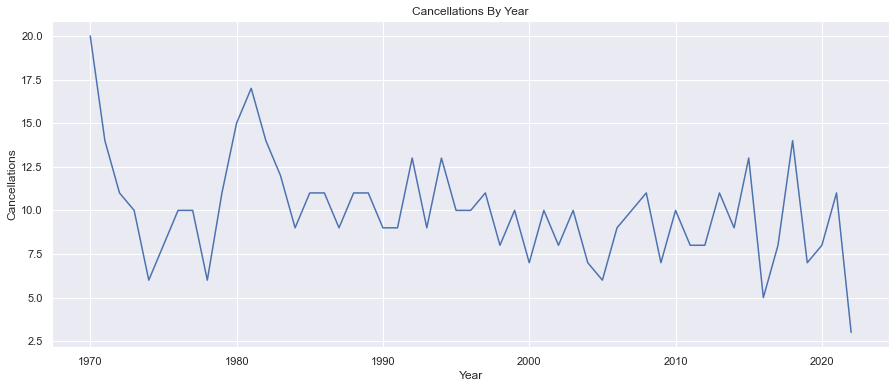

In [45]:
sns.lineplot(x="end_year", y="series_count", data=shonen_jump_yearly) 
plt.xlabel("Year")
plt.ylabel("Cancellations")
plt.title("Cancellations By Year") 

In [46]:
#see series lean towards short which is expected
shonen_jump_schedule['length_group'].value_counts()

short     293
medium    184
long       51
Name: length_group, dtype: int64